In [ ]:
#pip install catboost


In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from catboost import CatBoostRegressor
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.exceptions import ConvergenceWarning
from sklearn.linear_model import LogisticRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import RobustScaler,LabelEncoder
from sklearn.metrics import roc_auc_score,roc_curve, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV

import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


**Pandas Configuration**

In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
pd.set_option('display.float_format',  '{:.2f}'.format)

**Data set investigation**

In [ ]:
#dfOriginal = pd.read_csv('gdrive/My Drive/Colab Notebooks/Diabetics-project/diabetes.csv')
dfOriginal = pd.read_csv('gdrive/My Drive/Colab Notebooks/Diabetics-project/diabetes-dataset.csv')
df = dfOriginal.copy()
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.00,3.85,3.37,0.00,1.00,3.00,6.00,17.00
Glucose,768.00,120.89,31.97,0.00,99.00,117.00,140.25,199.00
BloodPressure,768.00,69.11,19.36,0.00,62.00,72.00,80.00,122.00
SkinThickness,768.00,20.54,15.95,0.00,0.00,23.00,32.00,99.00
Insulin,768.00,79.80,115.24,0.00,0.00,30.50,127.25,846.00
BMI,768.00,31.99,7.88,0.00,27.30,32.00,36.60,67.10
DiabetesPedigreeFunction,768.00,0.47,0.33,0.08,0.24,0.37,0.63,2.42
Age,768.00,33.24,11.76,21.00,24.00,29.00,41.00,81.00
Outcome,768.00,0.35,0.48,0.00,0.00,0.00,1.00,1.00


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [ ]:
def getDfProperties(data, head=5):
    print("\n Data frame Shape ")
    print(f'Shape     : {df.shape}\n'
          f'Size      : {df.size}\n'
          f'Dimension : {df.ndim}')
    print("\n\n Data Types ")
    print(data.dtypes)
    print("\n\n Head ")
    print(data.head(head))
    print("\n\n Tail ")
    print(data.tail(head))
    print("\n\n Random Sampling ")
    print(data.sample(head))
    print("\n \n Missing Values ")
    print(data.isnull().sum())
    print("\n \n Unique Values ")
    print(data.nunique())
    print("\n\n Describe ")
    print(data.describe().T)
    print("\n Duplicated Values ")
    print(data.duplicated().sum())

getDfProperties(df)


 Data frame Shape 
Shape     : (768, 9)
Size      : 6912
Dimension : 2


 Data Types 
Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object


 Head 
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  DiabetesPedigreeFunction  Age  Outcome
0            6      148             72             35        0 33.60                      0.63   50        1
1            1       85             66             29        0 26.60                      0.35   31        0
2            8      183             64              0        0 23.30                      0.67   32        1
3            1       89             66             23       94 28.10                      0.17   21        0
4            0      1

In [ ]:
def getColNames(dataframe, cat_th=10, car_th=20, print_results=True):
  cat_cols = [col for col in dataframe.columns if str(dataframe[col].dtypes) in ["category", "object", "bool"]]
  num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < 10 and dataframe[col].dtypes in ["int", "flaot"]]
  cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > 20 and str(dataframe[col].dtypes) in ["category", "object"]]
  cat_cols = [col for col in cat_cols if col not in cat_but_car]
  cat_cols = cat_cols + num_but_cat
  num_cols = [col for col in dataframe.columns if dataframe[col].dtypes in ["int", "float"]]
  num_cols = [col for col in num_cols if col not in cat_cols]

  if print_results:
      print(f'Observations {dataframe.shape[0]}')
      print(f'Variables:  {dataframe.shape[1]}')
      print(f'cat_cols:  {len(cat_cols)}')
      print(f'num_cols:  {len(num_cols)}')
      print(f'cat_but_car:  {len(cat_but_car)}')
      print(f'num_but_cat:  {len(num_but_cat)}')

  return cat_cols, num_cols, cat_but_car

In [ ]:
cat_cols, num_cols, cat_but_car = getColNames(df)


Observations 768
Variables:  9
cat_cols:  1
num_cols:  8
cat_but_car:  0
num_but_cat:  1


In [ ]:
def missingValueCheck(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")

    if na_name:
        return na_columns

missingValueCheck(df)

Empty DataFrame
Columns: [n_miss, ratio]
Index: []


In [ ]:
df[df['BMI'] < 12]

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
9,8,125,96,0,0,0.00,0.23,54,1
49,7,105,0,0,0,0.00,0.30,24,0
60,2,84,0,0,0,0.00,0.30,21,0
81,2,74,0,0,0,0.00,0.10,22,0
145,0,102,75,23,0,0.00,0.57,21,0
371,0,118,64,23,89,0.00,1.73,21,0
426,0,94,0,0,0,0.00,0.26,25,0
494,3,80,0,0,0,0.00,0.17,22,0
522,6,114,0,0,0,0.00,0.19,26,0
684,5,136,82,0,0,0.00,0.64,69,0


In [ ]:
missingValueCols = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]

for col in missingValueCols:
    print(col, df.loc[df[col] == 0].shape[0])
    df[col] = np.where(df[col] == 0, np.nan, df[col])

missingValueCheck(df)

Glucose 5
BloodPressure 35
SkinThickness 227
Insulin 374
BMI 11
               n_miss  ratio
Insulin           374  48.70
SkinThickness     227  29.56
BloodPressure      35   4.56
BMI                11   1.43
Glucose             5   0.65


In [ ]:
df = df.fillna(df.groupby('Outcome').transform('median'))

In [ ]:
def getOutlierThresholds(dataframe, variable, low_quantile=0.10, up_quantile=0.90):
    quantile_one = dataframe[variable].quantile(low_quantile)
    quantile_three = dataframe[variable].quantile(up_quantile)
    interquantile_range = quantile_three - quantile_one
    up_limit = quantile_three + 1.5 * interquantile_range
    low_limit = quantile_one - 1.5 * interquantile_range
    return  low_limit, up_limit

def checkOutlier(dataframe, col_name):
    low_limit, up_limit = getOutlierThresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

def drawOutliers(dataframe,title):
    a = 2
    b = 4
    c = 1
    results = []
    colors=[]

    palette_set3 = sns.color_palette("Set3",len(num_cols))
    for color in palette_set3.as_hex():
        colors.append(color)
    colour_num_cols = zip(num_cols, colors)

    fig = plt.figure(figsize = (20, 10))
    for col, color in colour_num_cols:
        plt.subplot(a, b, c)
        sns.boxplot(dataframe[col], color=color)
        plt.xlabel(f'{dataframe[col].name}', size=15)
        c = c + 1
        results.append(checkOutlier(dataframe, col))
        plt.suptitle(title, size=18);

    plt.tight_layout()
    plt.subplots_adjust(hspace=0.25)
    plt.show()

**CORRELATION**

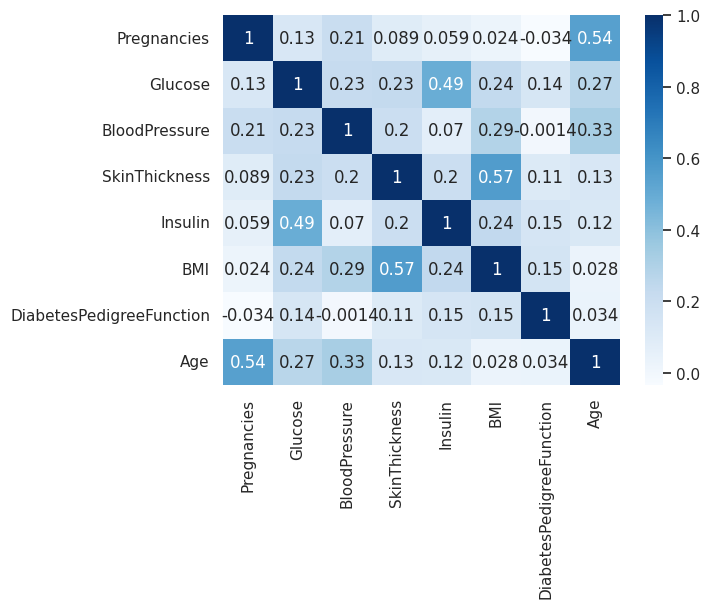

In [ ]:
corr = df[num_cols].corr()
sns.heatmap(corr, cmap="Blues", annot=True);

In [ ]:
def featureExtraction(dataframe):
    dataframe['Insulin_CAT'] = pd.cut(x=dataframe['Insulin'],
                                      bins=[0, 140, 199, np.inf],
                                      labels=["Normal", "Prediabetes", "Diabetes"])

    dataframe['BloodPressure_CAT'] = pd.cut(x=dataframe['BloodPressure'],
                                            bins=[0, 60, 80, 90, 120, np.inf],
                                            labels=["Low_Blood_Pressure", "Normal",
                                                    "Prehypertension", "Hypertension",
                                                    "Hypertensive_Crisis"])

    dataframe['Glucose_CAT'] = pd.cut(x=dataframe['Glucose'],
                                      bins=[0, 140, 199, np.inf],
                                      labels=["Normal", "Impaired_Glucose_Tolerance",
                                              "Diabetes"])

    dataframe['BMI_CAT'] = pd.cut(x=dataframe['BMI'],
                                  bins=[0, 18.5, 24.9, 29.9, 34.9, 39.9,  np.inf],
                                  labels=["Underweight", "Healthy", "Overweight",
                                          "Obese_Class1", "Obese_Class2", "Obese_Class3"])

    dataframe['Age_CAT'] = pd.cut(x=dataframe['Age'],
                                  bins=[20, 40, 60, np.inf],
                                  labels=["Adult", "Middle_Age_Adult", "Senior_Adult"])

    dataframe.loc[(dataframe['Age'] > 40)
                  & (dataframe['BloodPressure_CAT'] == 'Hypertension')
                  & ((dataframe["BMI_CAT"] == "Overweight")
                     | (dataframe["BMI_CAT"] == "Obese_Class1")
                     | (dataframe["BMI_CAT"] == "Obese_Class2")
                     | (dataframe["BMI_CAT"] == "Obese_Class3")), "Life_Level_CAT"] = "At_Risk"

    dataframe['Life_Level_CAT'].fillna('Not_Risk', inplace = True)

featureExtraction(df)



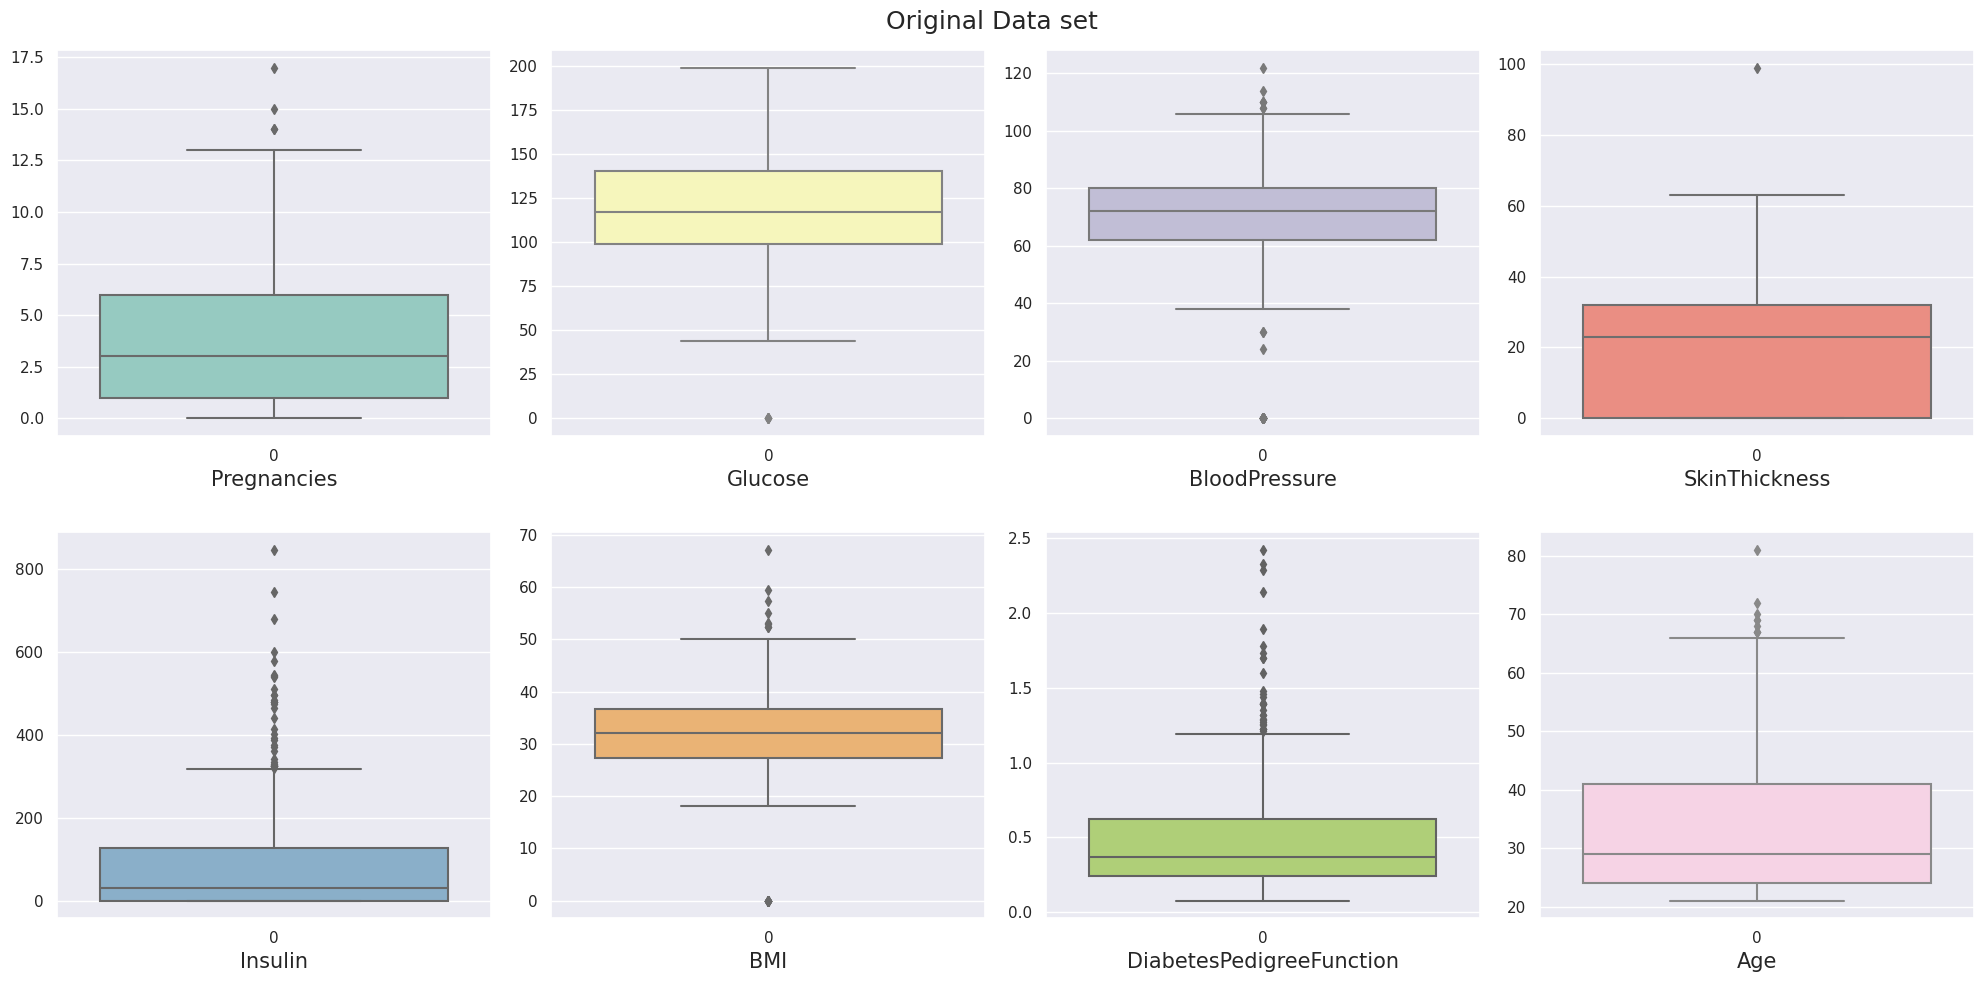

In [ ]:
drawOutliers(dfOriginal,"Original Data set")

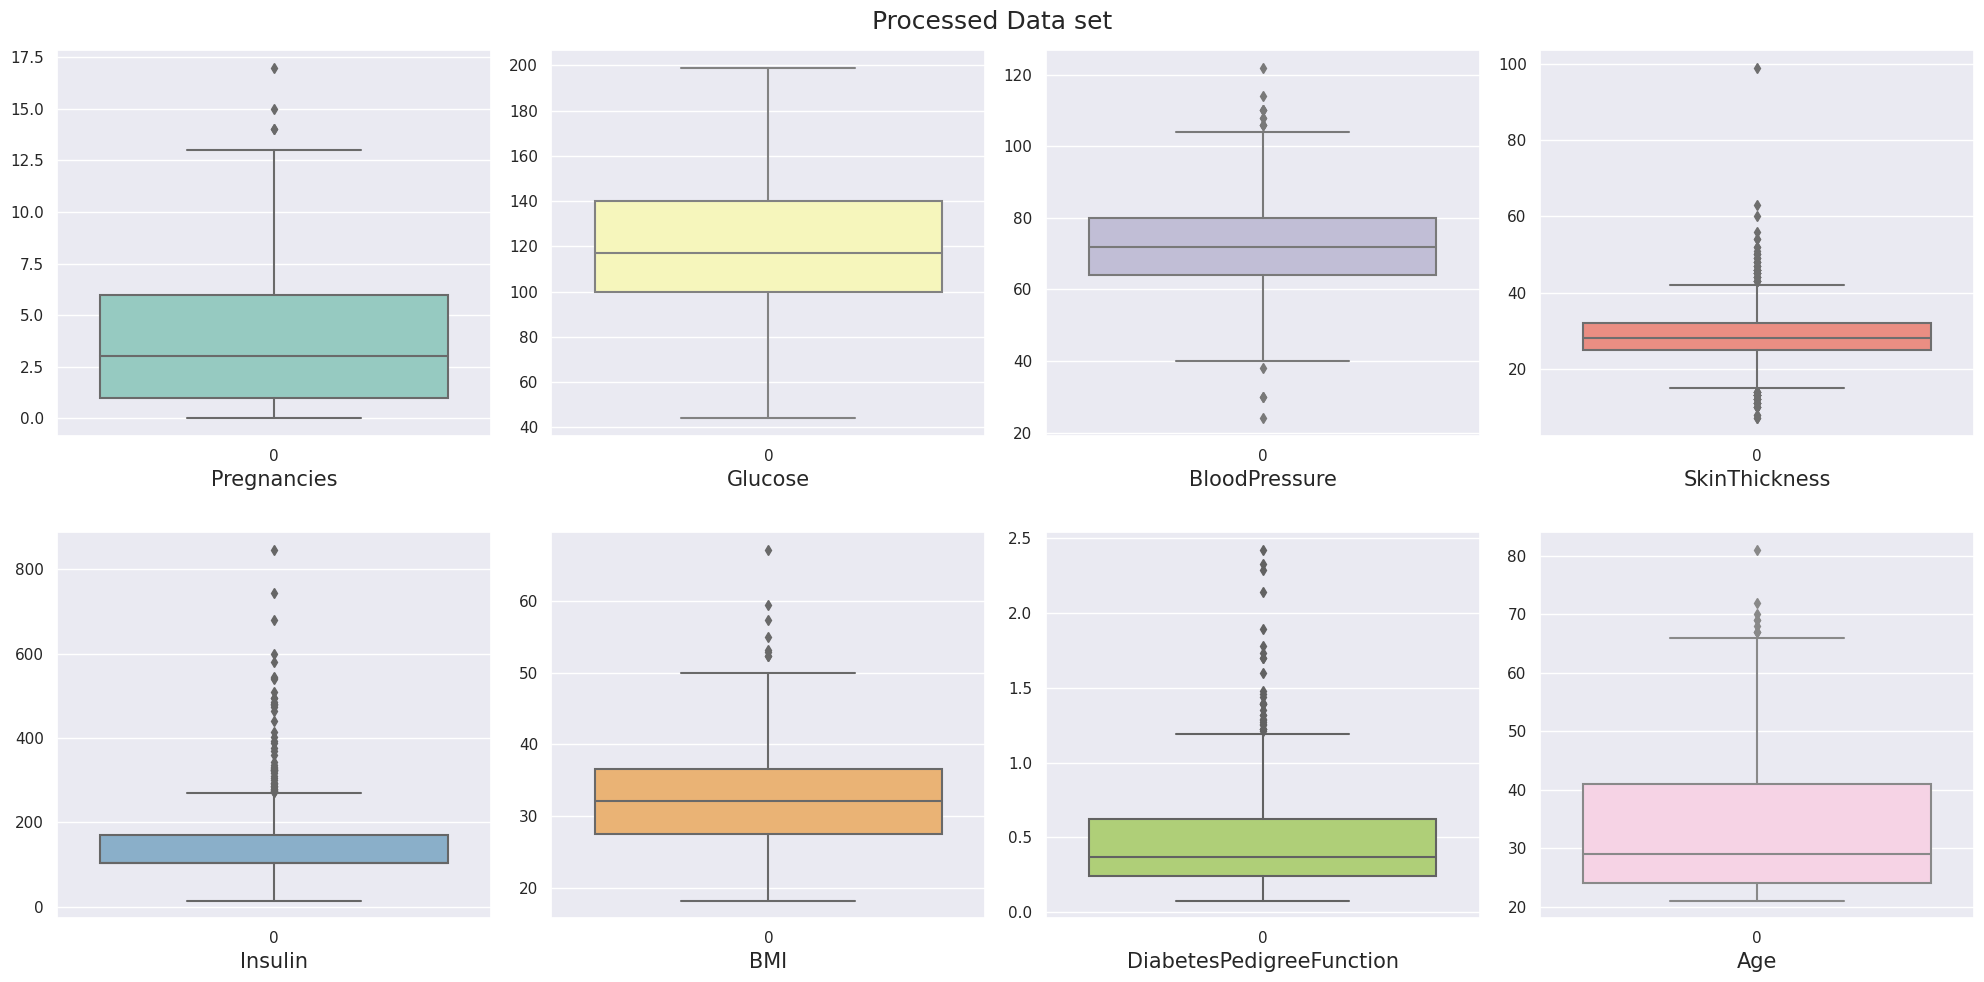

In [ ]:
drawOutliers(df,"Processed Data set")

In [ ]:
def drawHistPlot(dataframe, title):
    a = 4
    b = 2
    c = 1
    colors=[]
    missing_cols = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]
    palette_set2 = sns.color_palette("Paired",len(num_cols))
    for color in palette_set2.as_hex():
        colors.append(color)
    colour_num_cols = zip(missing_cols, colors)

    fig = plt.figure(figsize = (13, 15))
    for col, color in colour_num_cols:
        plt.subplot(a, b, c)
        sns.histplot(data=dataframe, x=col, kde=True, color=color);
        plt.xlabel(f'{dataframe[col].name}', size=15)
        c = c + 1
        plt.suptitle(title, size=18);

    plt.tight_layout()
    plt.subplots_adjust(hspace=0.25)
    plt.show()

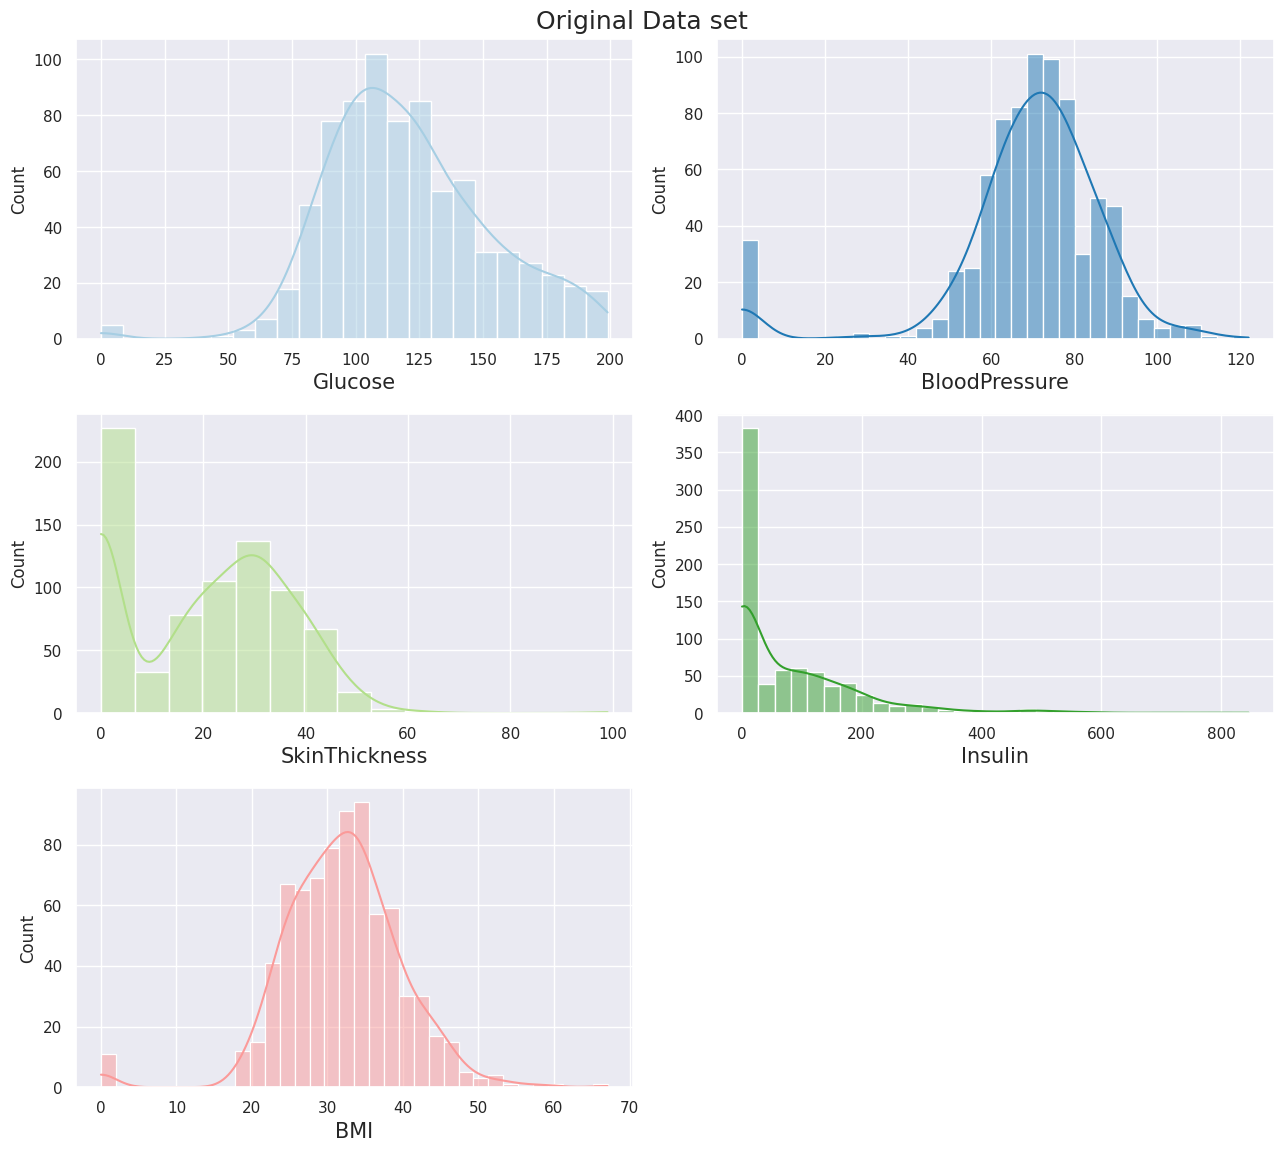

In [ ]:
drawHistPlot(dfOriginal,"Original Data set")

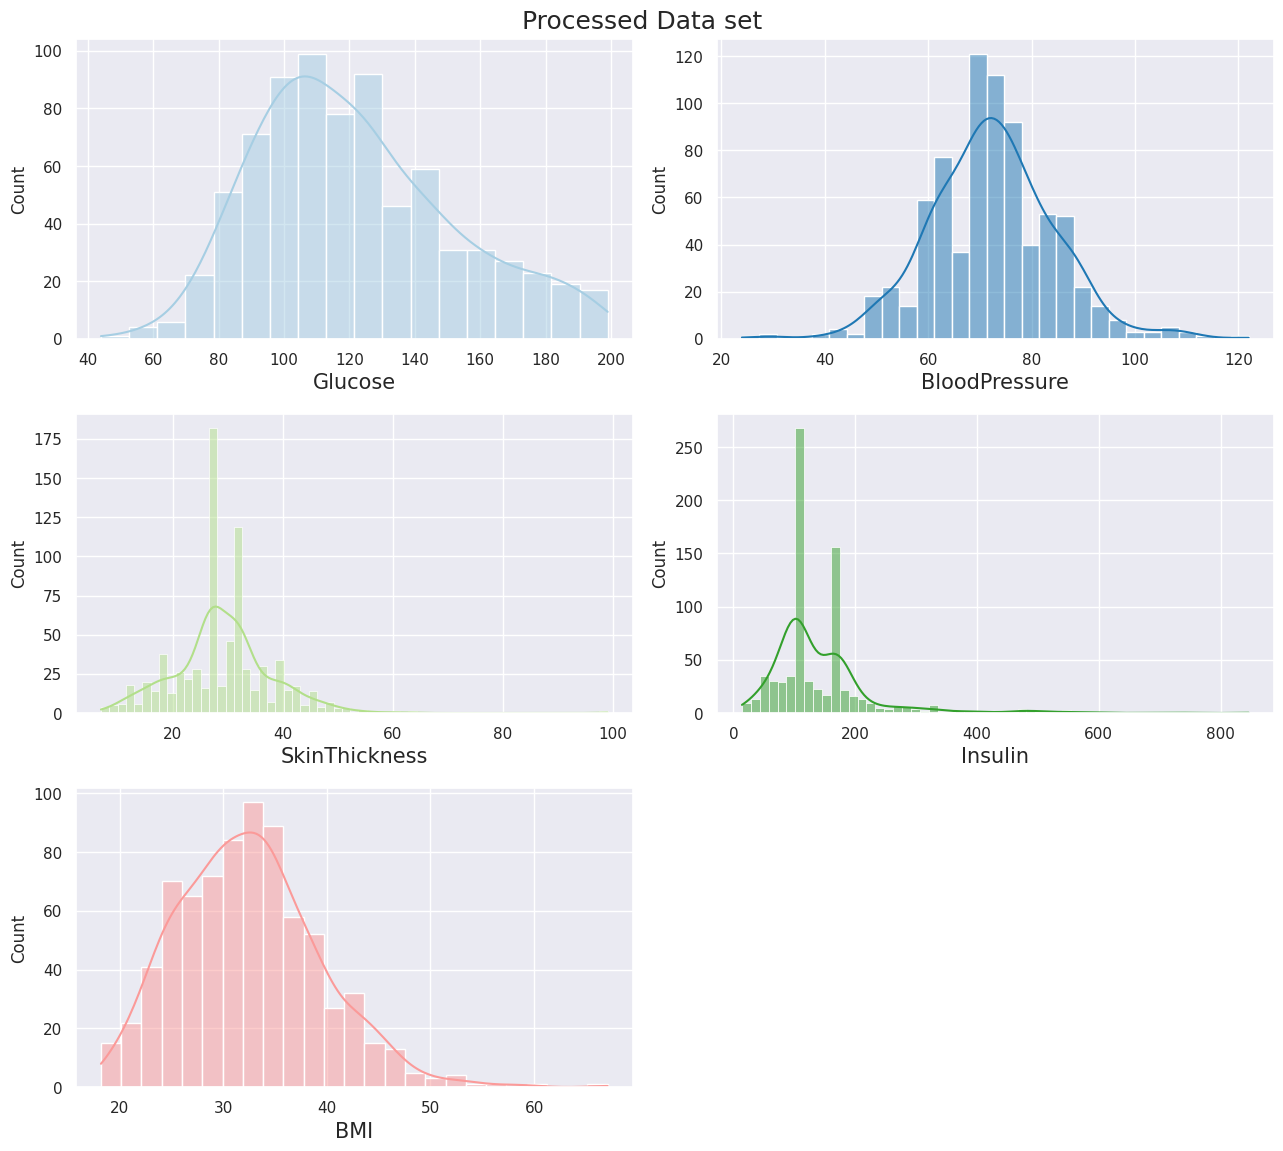

In [ ]:
drawHistPlot(df,"Processed Data set")

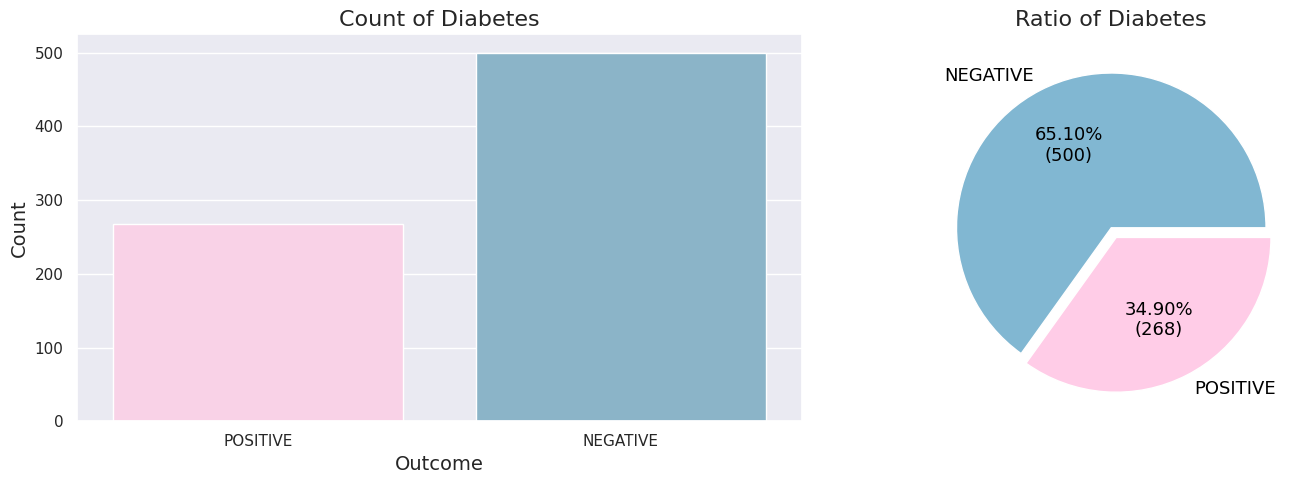

In [ ]:
  fig,  axs = plt.subplots(1,2, figsize = (15, 5))

ax = sns.countplot(data=df,
                   x=df['Outcome'].replace({0: 'NEGATIVE', 1: 'POSITIVE'}),
                   ax = axs[0],
                   palette=["#ffcce7", "#81b7d2"]);

ax.set_xlabel('Outcome', fontsize=14)
ax.set_ylabel('Count', fontsize=14)
axs[0].set_title("Count of Diabetes", fontsize=16)

def func(pct, allvals):
    absolute = int(np.round(pct/100.*np.sum(allvals)))
    return f"{pct:.2f}%\n({absolute:d})"

ax2 = df['Outcome'].value_counts().plot.pie(explode=[0,0.07],
                                                 colors=["#81b7d2", "#ffcce7"],
                                                 autopct=lambda pct: func(pct, df['Outcome'].value_counts()),
                                                 ylabel='',
                                                 labels=['NEGATIVE', 'POSITIVE'],
                                                 ax = axs[1],
                                                 textprops=dict(color="black", size=13));
axs[1].set_title("Ratio of Diabetes", fontsize=16)

plt.tight_layout()
plt.show()

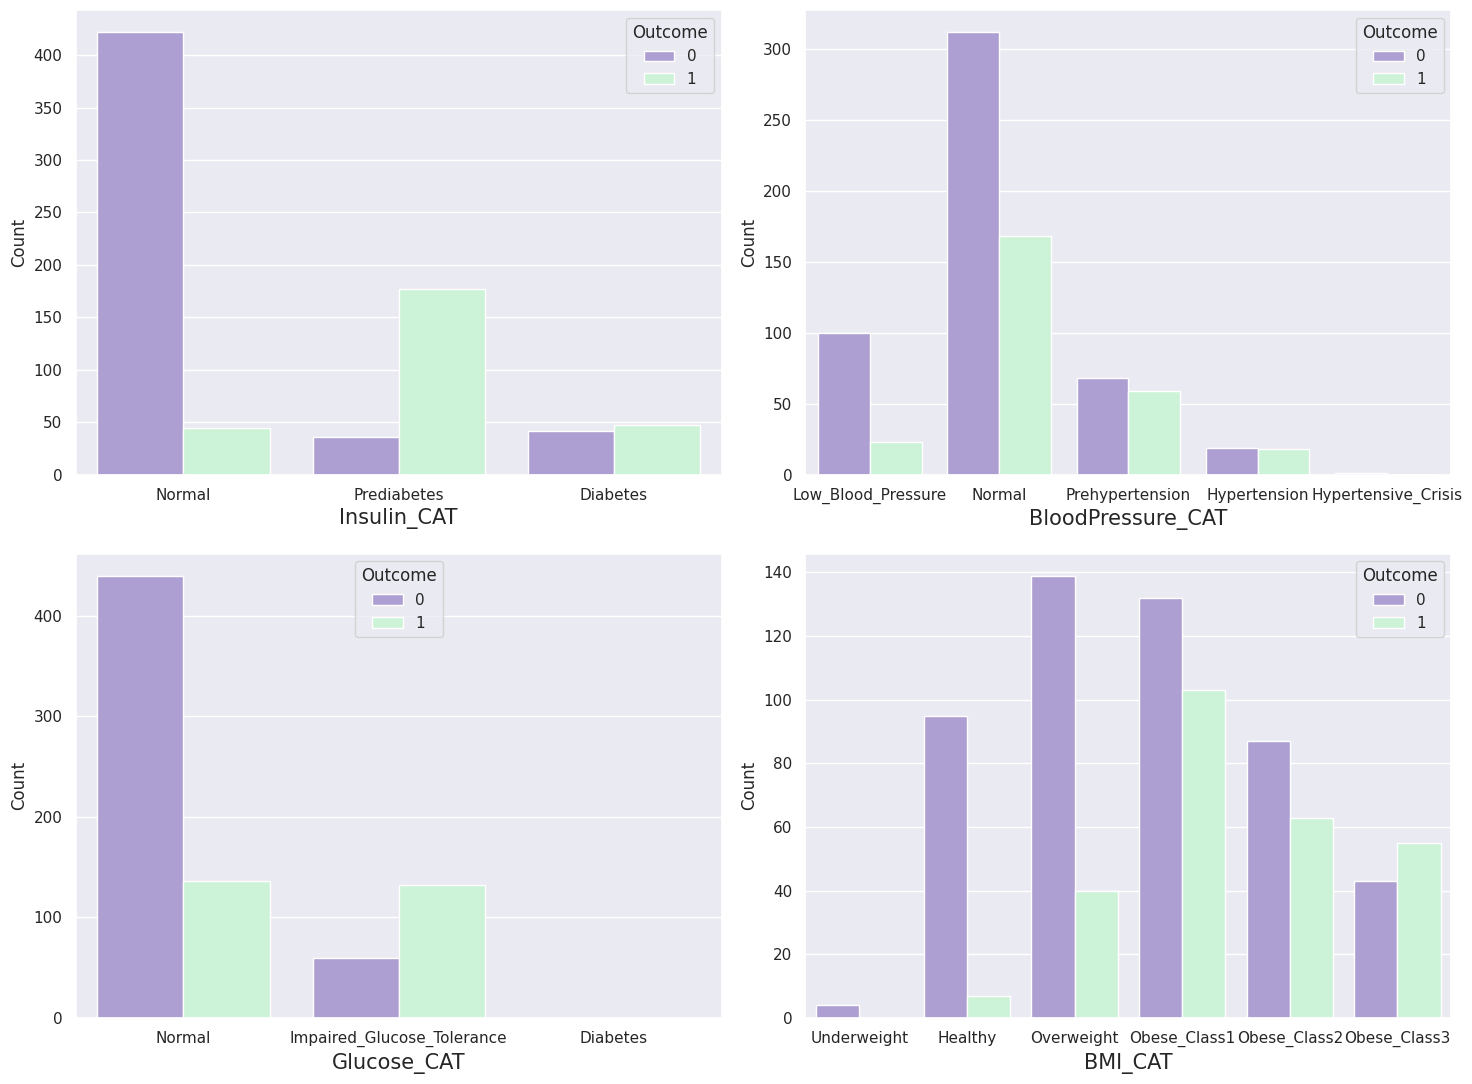

In [ ]:
newCols = ["Insulin_CAT", "BloodPressure_CAT", "Glucose_CAT", "BMI_CAT"]

a = 2
b = 2
c = 1
fig = plt.figure(figsize = (15, 11))
for col in newCols:
    plt.subplot(a, b, c)
    ax = sns.countplot(df,
                       x=df[col],
                       hue=df.Outcome,
                       palette=["#AA96DA", "#C5FAD5"])
    plt.ylabel('Count')
    plt.xlabel(f'{col}', size=15)
    c = c + 1

plt.tight_layout()
plt.subplots_adjust(hspace=0.17)
plt.show()

**ML**

In [ ]:
def oneHotEncoder(dataframe, categorical_col, drop_first=True):
    dataframe = pd.get_dummies(dataframe, columns=categorical_col, drop_first=drop_first)
    return dataframe

In [ ]:
def labelEncoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe

In [ ]:
def dataPrep(X, y):

    index = X.index
    dataframe = X.merge(y.to_frame(), left_index=True, right_index=True).set_index(index)

    # get cols
    cat_cols, num_cols, cat_but_car = getColNames(dataframe, print_results=False)

    # replace outliers
    [checkOutlier(dataframe, col) for col in num_cols]

    # Treat zero values as missing values after acquiring domain knowledge
    missing_value = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]
    for col in missing_value:
        dataframe[col] = np.where(dataframe[col] == 0, np.nan, dataframe[col])
    dataframe = dataframe.fillna(dataframe.groupby('Outcome').transform('median'))

    # Feature Engineering
    featureExtraction(dataframe)

    # Scaling
    rs = RobustScaler()
    dataframe[num_cols] = rs.fit_transform(dataframe[num_cols])

    # binary encoding
    binary_cols = [col for col in dataframe.columns
                   if dataframe[col].dtype not in ["int64", "float64"]
                   and dataframe[col].nunique() == 2]
    for col in binary_cols:
        labelEncoder(dataframe, col)

    # One-hot-encoding
    ohe_cols = [col for col in dataframe.columns if 12 >= dataframe[col].nunique() > 2]
    dataframe = oneHotEncoder(dataframe, ohe_cols, drop_first=True)

    X = dataframe.drop(["Outcome"], axis=1)
    y = dataframe["Outcome"]
    return X, y

fitting original DF

In [ ]:
X = df.drop(["Outcome"], axis=1)
y = df["Outcome"]
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.20, random_state=42)

Defining model function

In [ ]:
X_train, y_train = dataPrep(X_train, y_train)
X_test, y_test = dataPrep(X_test, y_test)

In [ ]:
def base_models(X, y):
    models = [("Logistic Regression", LogisticRegression(solver='lbfgs', max_iter=3000)),
              ("Decision Tree Classifier", DecisionTreeClassifier()),
              ("Random Forest Classifier", RandomForestClassifier()),
              ("LGBM Classifier", LGBMClassifier()),]
    for name, classifier in models:
        cv_results = cross_validate(classifier, X, y, cv=5, scoring="accuracy")
        print(f"Accuracy: {round(cv_results['test_score'].mean(), 4)} ({name}) ")

In [ ]:
cart_params = {'max_depth': range(1, 20),
               "min_samples_split": range(2, 30)}

rf_params = {"max_depth": [8, 15, None],
             "max_features": [5, 7],
             "min_samples_split": [15, 20],
             "n_estimators": [200, 300]}

lightgbm_params = {"learning_rate": [0.01, 0.1],
                   "n_estimators": [300, 500, 1500],
                   "colsample_bytree": [0.5, 0.7, 1]}

In [ ]:
classifiers  =[("Decision Tree Classifier", DecisionTreeClassifier(), cart_params),
               ("Random Forest Classifier", RandomForestClassifier(), rf_params),
               ('LGBM Classifier', LGBMClassifier(), lightgbm_params)]

In [ ]:
def hyperparameterOptimization(X, y, cv=5, scoring="accuracy"):
    print("\nHyperparameter Optimization....")
    best_models = {}
    for name, classifier, params in classifiers:
        print(f"------------------------------- {name} -------------------------------")
        cv_results = cross_validate(classifier, X, y, cv=cv, scoring=scoring)
        print(f"{scoring} (Before): {round(cv_results['test_score'].mean(), 4)}")

        gs_best = GridSearchCV(classifier, params, cv=cv, n_jobs=-1, verbose=False).fit(X, y)
        final_model = classifier.set_params(**gs_best.best_params_)

        cv_results = cross_validate(final_model, X, y, cv=cv, scoring=scoring)
        print(f"{scoring} (After): {round(cv_results['test_score'].mean(), 4)}")
        print(f"{name} best params: {gs_best.best_params_}", end="\n\n")
        best_models[name] = final_model
    return best_models

In [ ]:
def votingClassifier(best_models, X, y):
    print("\nVoting Classifier...")
    voting_clf = VotingClassifier(estimators=[('Random Forest Classifier', best_models["Random Forest Classifier"]),
                                              ('LGBM Classifier', best_models["LGBM Classifier"])],
                                  voting='soft').fit(X, y)
    cv_results = cross_validate(voting_clf, X, y, cv=3, scoring=["accuracy", "f1", "roc_auc"])
    print(f"Accuracy: {cv_results['test_accuracy'].mean()}")
    print(f"F1Score: {cv_results['test_f1'].mean()}")
    print(f"ROC_AUC: {cv_results['test_roc_auc'].mean()}")
    return voting_clf

In [ ]:
def fitModels(X,y):
    base_models(X, y)
    best_models = hyperparameterOptimization(X, y)
    voting_clf = votingClassifier(best_models, X, y)
    return voting_clf, best_models

voting_clf, best_models = fitModels(X_train, y_train)

Accuracy: 0.8682 (Logistic Regression) 
Accuracy: 0.8436 (Decision Tree Classifier) 
Accuracy: 0.8844 (Random Forest Classifier) 
Accuracy: 0.891 (LGBM Classifier) 

Hyperparameter Optimization....
------------------------------- Decision Tree Classifier -------------------------------
accuracy (Before): 0.8534
accuracy (After): 0.8632
Decision Tree Classifier best params: {'max_depth': 5, 'min_samples_split': 5}

------------------------------- Random Forest Classifier -------------------------------
accuracy (Before): 0.891
accuracy (After): 0.8845
Random Forest Classifier best params: {'max_depth': 8, 'max_features': 7, 'min_samples_split': 15, 'n_estimators': 200}

------------------------------- LGBM Classifier -------------------------------
accuracy (Before): 0.891
accuracy (After): 0.899
LGBM Classifier best params: {'colsample_bytree': 0.5, 'learning_rate': 0.1, 'n_estimators': 1500}


Voting Classifier...
Accuracy: 0.8925314841383708
F1Score: 0.8440800876157666
ROC_AUC: 0.948

In [ ]:
lgbm_model = best_models['LGBM Classifier'].fit(X_train, y_train)

In [ ]:
model_save_path = 'lgbm_Diabetes_classifier_model.txt'

# Save the trained model to the specified path

lgbm_model.booster_.save_model(model_save_path)

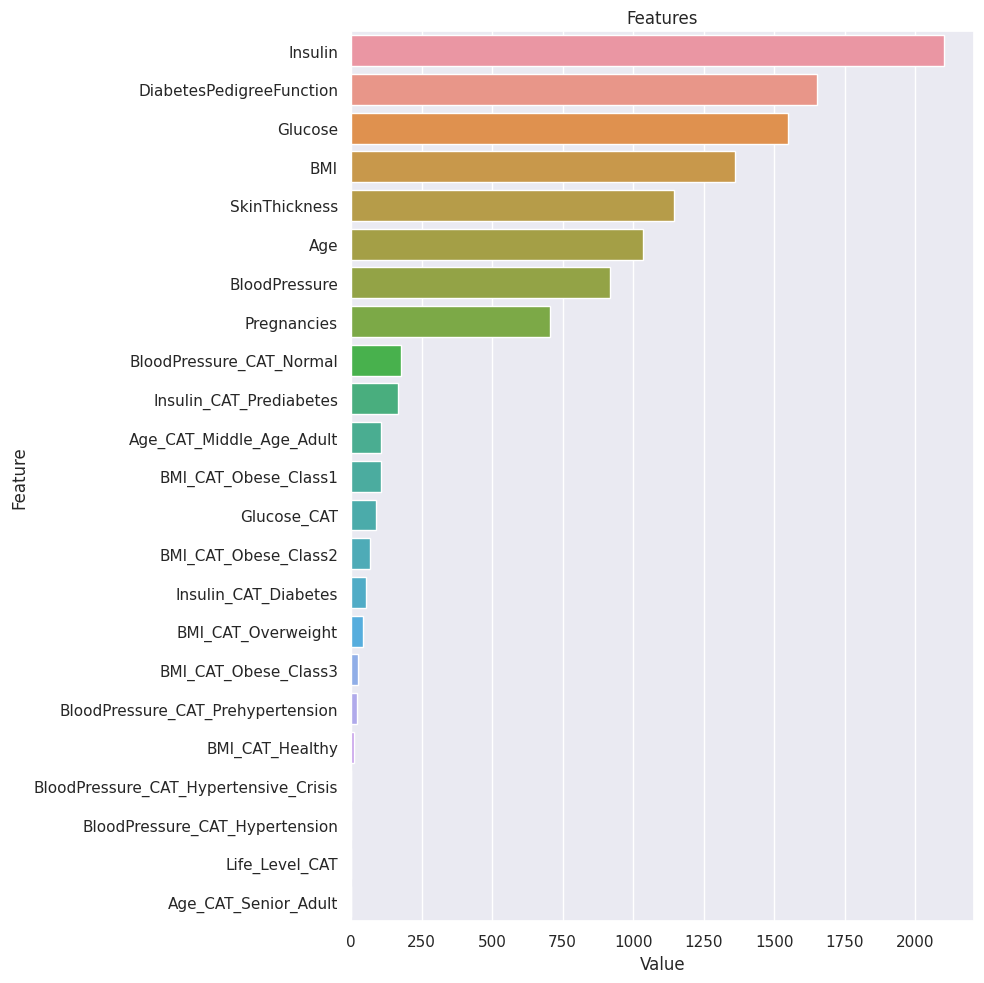

In [ ]:
def plot_importance(model, features, num=len(X)):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_,
                                'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()

plot_importance(lgbm_model, X_train)

In [ ]:
y_pred = lgbm_model.predict(X_test)
y_prob = lgbm_model.predict_proba(X_test)[:, 1]
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.86      0.86        99
           1       0.75      0.75      0.75        55

    accuracy                           0.82       154
   macro avg       0.80      0.80      0.80       154
weighted avg       0.82      0.82      0.82       154



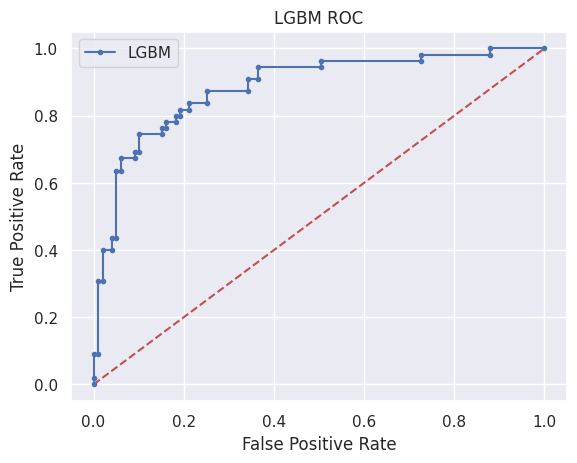

In [ ]:
lgbm_roc_auc = roc_auc_score(y_test, y_prob)
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure()

plt.plot([0,1],[0,1],'r--')
plt.plot(fpr, tpr, marker='.', label='LGBM')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("LGBM ROC")
plt.legend()
plt.show()

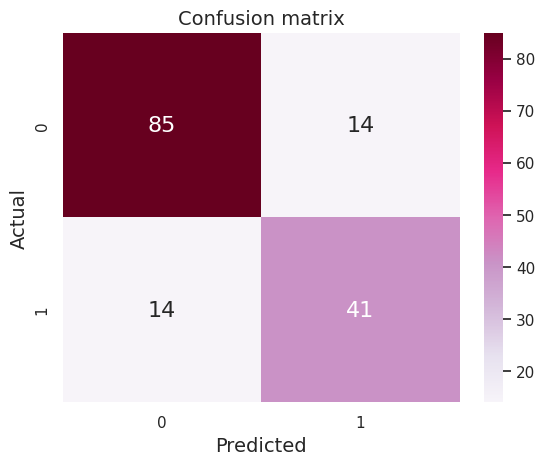

In [ ]:
cnf_matrix = confusion_matrix(y_test, y_pred)
p = sns.heatmap(pd.DataFrame(cnf_matrix ),
                annot=True,
                cmap="PuRd",
                annot_kws={"size": 16})
plt.title('Confusion matrix', size=14)
plt.ylabel('Actual', size=14)
plt.xlabel('Predicted', size=14);